# Titanic Survival with DNN

Supervised Learning. Binary classification

Predict survival on the Titanic using an artificial neural network in Keras

This project is based on a dataset containing demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. A description of this dataset is on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper

helper.reproducible(seed=0)  # Setup reproducible results from run to run using Keras
sns.set()

Using TensorFlow backend.


## 1. Data processing and Exploratory Data Analysis

In [2]:
data_path = 'data/titanic_data.csv'
target = ['Survived']  # the target will remain the same throughout the notebook

original_df = pd.read_csv(data_path)
print("{} rows \n{} columns \ntarget: {}".format(*original_df.shape, target))

891 rows 
12 columns 
target: ['Survived']


### Show original data

In [3]:
original_df.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


#### Numerical Data

In [4]:
original_df.describe(percentiles=[0.5])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Non-numerical Data

In [5]:
original_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Kelly, Miss. Mary",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


#### Missing values

Missing:
                 Age:    177/891 (19.9%)
               Cabin:    687/891 (77.1%)
            Embarked:      2/891 (0.2%)


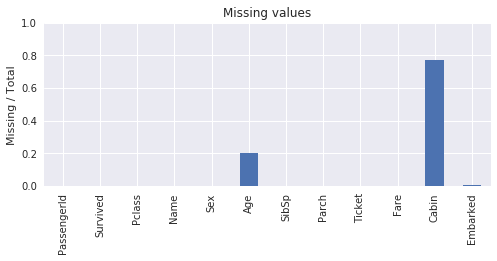

In [6]:
helper.show_missing(original_df, plot=True)

- Binary target "Survived": ~38% ones; F1 score won't be used <br>
- Some values are missing for key values (e.g. Age)
- Some features (e.g. PassengerID, Name, Ticket) seem irelevant to survival probabilities <br> 

### Transform features

#### Enhance and add new features

In [7]:
df = original_df.copy()  # modified dataset


def enhance_features(df, inplace=False):
    """ Enchance dataframe df """

    if not inplace:
        df = df.copy()
        
    # filter Cabin to first letter
    df["Cabin"] = df["Cabin"].str[0]

    # get Title from Name
    df['Title'] = df["Name"].str.extract('([A-Za-z]+)\.', expand=False)

    # remove low frequency values for the new feautres
    fields = ['Cabin', 'Title']
    df.loc[:, fields] = helper.remove_lowfreq(df.loc[:, fields], show=True)

    # Alone passenger
    df['Alone'] = ((df["SibSp"] + df["Parch"]) == 0)
    
    if not inplace:
        return df


enhance_features(df, inplace=True)

Cabin {'C': 59, 'B': 47, 'D': 33, 'E': 32, 'A': 15, 'F': 13}
Title {'Mr': 517, 'Miss': 182, 'Mrs': 125, 'Master': 40}


#### Delete irrelevant features


In [8]:
def drop_irrelevant_features(df, inplace=False):
    """ Remove non-relevant columns from dataftame df (inplace) """
    
    if not inplace:
        df = df.copy()
        
    df.drop(['PassengerId', 'Name', 'Ticket'], axis='columns', inplace=True)

    if not inplace:
        return df

    
drop_irrelevant_features(df, inplace=True)

### Classify variables

Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [9]:
# numerical = list(df.select_dtypes(include=[np.number]))
df = helper.classify_data(df, target, numerical=["Age", "SibSp", "Parch", "Fare"])

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head() # show data types

,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked,Title,Alone,Survived
Type,float64,int64,int64,float64,category,category,category,category,category,category,category


### Visualize the data

#### Categorical features

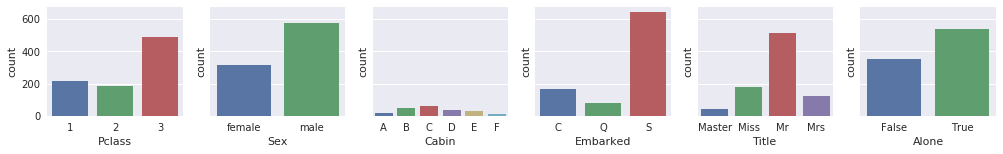

In [10]:
helper.show_categorical(df, target=target, sharey=True)

#### Target vs Categorical features

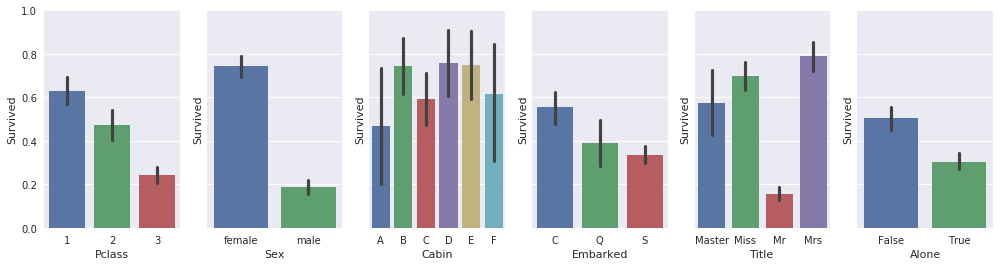

In [11]:
helper.show_target_vs_categorical(df, target)
plt.ylim([0, 1]);

#### Numerical features

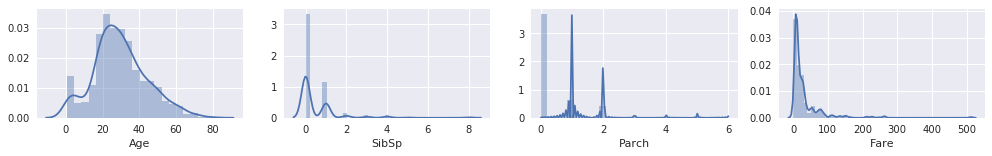

In [12]:
helper.show_numerical(df, kde=True)

#### Target vs numerical features

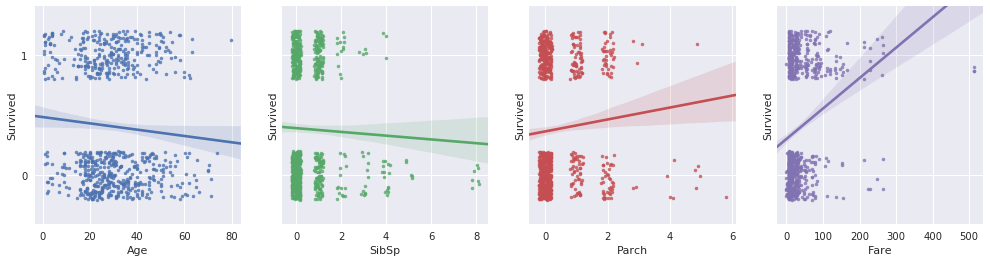

In [13]:
helper.show_target_vs_numerical(df, target, jitter=0.2)
plt.ylim([-0.4, 1.4])
plt.yticks([0, 1]);
#df.groupby('Survived')['Age'].hist(alpha=0.4)
# helper.show_target_vs_numerical(df_3sigma, target, numerical, jitter=0.2)

#### Correlation between numerical features and target

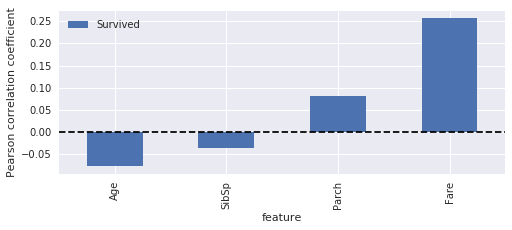

In [14]:
helper.show_correlation(df, target)

#### Most relevant features

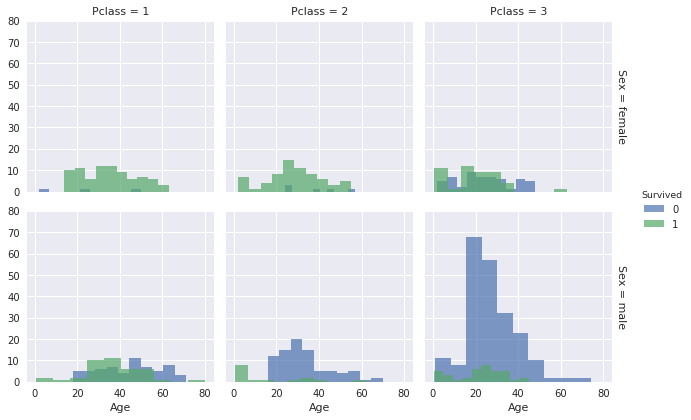

In [15]:
sns.FacetGrid(
    df, row="Sex", col="Pclass", hue="Survived", size=3, margin_titles=True).map(
        plt.hist, "Age", alpha=.7).add_legend()
plt.ylim([0, 80]);
# df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(
#     by='Survived', ascending=False)
# helper.show_target_vs_categorical(df.loc[(df['Age']<12) | (df['Sex']=='female')],
#                                   target, categorical)

-  Unlike in third class, most children and women in first and second classes survived.

### Fill missing values

In [16]:
helper.show_missing(original_df)

Missing:
                 Age:    177/891 (19.9%)
               Cabin:    687/891 (77.1%)
            Embarked:      2/891 (0.2%)


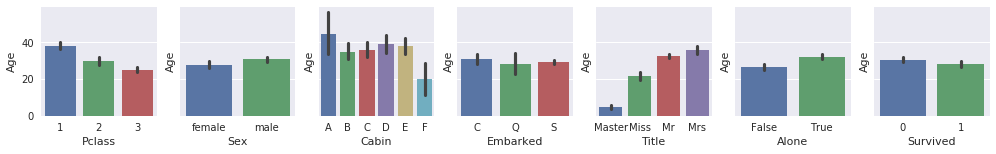

In [17]:
helper.show_target_vs_categorical(df, ['Age'], figsize=(17, 2))  # Age vs categorical

In [18]:
def fill_missing_values(df, inplace=False):
    """ Fill missing values of the dataframe df """

    if not inplace:
        df = df.copy()

    categorical = list(df.select_dtypes(include=['category']))
    # the median of Age for different Pclass and Tittle will be used
    ref = df.groupby(['Pclass', 'Title'])['Age'].transform('median')
    df['Age'].fillna(ref, inplace=True)

    # fill missing categorical values with the mode (if any)
    modes = df[categorical].mode()  # this solves fillna issue with mode()
    for idx, f in enumerate(df[categorical]):
        df[f].fillna(modes.iloc[0, idx], inplace=True)

    # fill missing numeric NaN values with the median (if any)
    df.fillna(df.median(), inplace=True)

    if not inplace:
        return df


fill_missing_values(df, inplace=True)
copy_df = df.copy()  # save checkpoint

# # Changing Age to categorized intervals does not improve the NN model:

# bins = list(range(0,80,10))
# # bins = (0, 5, 10, 15, 20, 30, 40, 50, 60)
# labels = ["{}-{}".format(i, j) for i,j in zip(bins[:-1],bins[:-1])]
# df['Age_cat'] = pd.cut(df['Age'], bins, labels=labels).astype('category')
# df = df.drop(['Age'], axis='columns')

df.head()

,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked,Title,Alone,Survived
0,22.0,1,0,7.2500,3,male,C,S,Mr,False,0
1,38.0,1,0,71.2833,1,female,C,C,Mrs,False,1
2,26.0,0,0,7.9250,3,female,C,S,Miss,True,1
3,35.0,1,0,53.1000,1,female,C,S,Mrs,False,1
4,35.0,0,0,8.0500,3,male,C,S,Mr,True,0


## 2. Neural Network model

### Select the features for the model

In [19]:
drop_features = []  # features to drop

df = copy_df.copy()  # Restore checkpoint

df.drop(drop_features, axis='columns', inplace=True)
# From now use data instead of df
data = df.copy()
data.head()

,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked,Title,Alone,Survived
0,22.0,1,0,7.2500,3,male,C,S,Mr,False,0
1,38.0,1,0,71.2833,1,female,C,C,Mrs,False,1
2,26.0,0,0,7.9250,3,female,C,S,Miss,True,1
3,35.0,1,0,53.1000,1,female,C,S,Mrs,False,1
4,35.0,0,0,8.0500,3,male,C,S,Mr,True,0


### Normalize numerical variables

Shift and scale the variables such that they have zero mean and a standard deviation of 1. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [20]:
data, scale = helper.normalize(data)

### Create dummy features

In [21]:
# features only; target should be encoded later
data, dummies = helper.create_dummy(data, target)

# ordered neural network features (with dummies)
nn_features = [f for f in data if f not in target]

data.head()

,Age,SibSp,Parch,Fare,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Cabin_F,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Alone_False,Alone_True
0,-0.528175,0.432550,-0.473408,-0.502163,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
1,0.658128,0.432550,-0.473408,0.786404,1,1,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
2,-0.231600,-0.474279,-0.473408,-0.488580,1,0,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1
3,0.435696,0.432550,-0.473408,0.420494,1,1,0,0,1,0,...,0,0,0,1,0,0,0,1,1,0
4,0.435696,-0.474279,-0.473408,-0.486064,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1


### Split the data into training, and test sets

In [22]:
from sklearn.model_selection import train_test_split


def split(data, test_size=0.25):
    train, test = train_test_split(data, test_size=0.25, random_state=9)

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_test, y_test = test.drop(target, axis=1).values, test[target].values
    # _nc: non-categorical yet (needs one-hot encoding)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = split(data, test_size=0.25)

### One-hot encode the output

In [23]:
def one_hot_output(y_train, y_test):
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return y_train, y_test


y_train, y_test = one_hot_output(y_train, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(668, 24) (668, 2)
(223, 24) (223, 2)


### Build the Neural Network

In [24]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size
    weights = keras.initializers.RandomNormal(stddev=0.0001)

    model = Sequential()
    model.add(
        Dense(
            input_nodes,
            input_dim=input_size,
            activation='relu',
            kernel_initializer=weights,
            bias_initializer='zero'))

    model.add(Dropout(.2))

    model.add(
        Dense(
            output_size,
            activation='softmax',
            kernel_initializer=weights,
            bias_initializer='zero'))

    if summary:
        model.summary()

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


model = build_nn(x_train.shape[1], y_train.shape[1], summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________


### Train the Neural Network


Training ....
time: 	 3.1 s


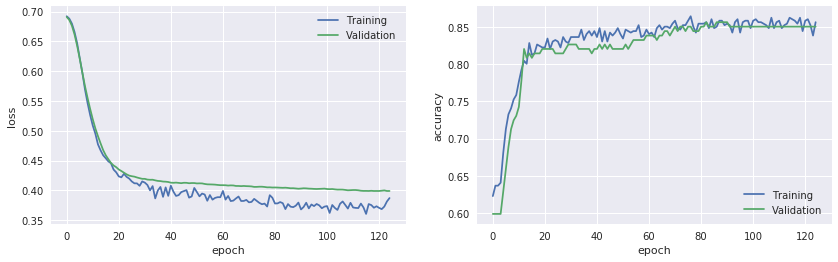


Training loss:  	0.3870
Validation loss: 	0.3989

Training accuracy: 	0.856
Validation accuracy:	0.850

Model saved at models/titanic.h5


In [25]:
from time import time
model_path = os.path.join("models", "titanic.h5")


def train_nn(model, x_train, y_train, path=False, show=True):
    print('\nTraining ....')
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=1000,
        batch_size=64,
        verbose=0,
        validation_split=0.25,
        callbacks=callbacks)

    print("time: \t {:.1f} s".format(time() - t0))

    if show:
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)


model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, path=model_path)

### Evaluate the model

In [26]:
def evaluate_nn(model, x_test, y_test):
    score = model.evaluate(x_test, y_test, verbose=0)
    print("\nTest Accuracy: {:.3f}".format(score[1]))


#model = keras.models.load_model(model_path)
evaluate_nn(model, x_test, y_test)


Test Accuracy: 0.821


### Make predictions

In [27]:
def predict_manual(new_df):
    """
    input: custom dataframe 
    """
    
    new_data = new_df.copy()
    
    # force data types to previous dataframe df 
    for col in list(new_data):
        new_data[col] = new_data[col].astype(df.dtypes[col])
    
    # normalize numerical variables
    new_data, _ = helper.normalize(new_data, scale)
    
    # replace categorical features by dummy variables (using existing dummies)
    new_data, _ = helper.create_dummy(new_data, target, dummies)

    # sort columns to match with manual entries
    new_data = new_data[nn_features] ## nn_features: sorted list used in the NN model

    # make predictions
    prediction = model.predict(new_data.values)[:, 1]
    return (prediction)


#     for index, row in new_data.iterrows():
#         single_pred = model.predict(np.array([row]))
#         print('{}:\t {:.0f}%'.format(index,single_pred[0,1] * 100))

In [28]:
# input data format
df.describe()

,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,29.123648,0.523008,0.381594,32.204208
std,13.487280,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.910400
50%,26.000000,0.000000,0.000000,14.454200
75%,36.250000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [29]:
df.describe(include=['category'])

,Pclass,Sex,Cabin,Embarked,Title,Alone,Survived
count,891,891,891,891,891,891,891
unique,3,2,6,3,4,2,2
top,3,male,C,S,Mr,True,0
freq,491,577,751,646,544,537,549


In [30]:
print(list(df))

['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex', 'Cabin', 'Embarked', 'Title', 'Alone', 'Survived']


In [31]:
new_passengers = {
    'Average man':    [26, 1, 0, 14, 2, 'male',   'C', 'S', 'Mr', 0],
    'Average woman':  [26, 1, 0, 14, 2, 'female', 'C', 'S', 'Mrs', 0],
    'Alone woman 3c': [26, 0, 2, 8, 3, 'female',  'C', 'S', 'Miss', 1],
    'Boy 1c ':        [7, 0, 2, 31, 1, 'male',    'C', 'S', 'Master', 0],
    'Boy 2c ':        [7, 0, 2, 14, 2, 'male',    'C', 'S', 'Master', 0],
    'Boy 3c ':        [7, 0, 2, 8, 3, 'male',     'C', 'S', 'Master', 0],
}

# create a dataframe with the new data
new_df = pd.DataFrame(
    data=list(new_passengers.values()),
    index=new_passengers.keys(),
    columns= [f for f in list(df) if f not in target])

prediction = predict_manual(new_df)
new_df['Survival prob. (%)'] = (prediction * 100).astype(int)
new_df

,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked,Title,Alone,Survival prob. (%)
Average man,26,1,0,14,2,male,C,S,Mr,0,10
Average woman,26,1,0,14,2,female,C,S,Mrs,0,92
Alone woman 3c,26,0,2,8,3,female,C,S,Miss,1,32
Boy 1c,7,0,2,31,1,male,C,S,Master,0,93
Boy 2c,7,0,2,14,2,male,C,S,Master,0,91
Boy 3c,7,0,2,8,3,male,C,S,Master,0,54


The results predicted from the model confirm the impact of the sex for the survival probabilities, as well as the class for the survival of women and children.

### Compare with non-enhanced features

In [32]:
# Same dataset without:
#   enhancing features
#   adding new features
#   filling missing values using grouped median

df2 = original_df.copy()

# select features & classify features
df2.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis='columns', inplace=True)
df2 = helper.classify_data(df2, target, numerical=["Age", "SibSp", "Parch", "Fare"])

# fill NaN
df2.fillna(df2.median(), inplace=True)

# Normalize and create dummies
data2, _ = helper.normalize(df2)
data2, _ = helper.create_dummy(data2, target)

# split and one-hot output
x_train2, y_train2, x_test2, y_test2 = split(data2, test_size=0.25)
y_train2, y_test2 = one_hot_output(y_train2, y_test2)

# build, train and evaluate model
model2 = build_nn(x_train2.shape[1], y_train2.shape[1], summary=False)
train_nn(model2, x_train2, y_train2, path=False, show=False)
evaluate_nn(model2, x_test2, y_test2)


Training ....
time: 	 3.0 s

Test Accuracy: 0.780


### Compare removing outliers

In [33]:
df3 = original_df.copy()

# transform features
enhance_features(df3, inplace=True)

# select features & classify features
df3.drop(['PassengerId', 'Name', 'Ticket'], axis='columns', inplace=True)
df3 = helper.classify_data(df3, target, numerical=["Age", "SibSp", "Parch", "Fare"])

# remove outliers
helper.remove_outliers(df3, inplace=True)  # remove default values above 3 times standard deviation

# fill missing values (enhanced)
fill_missing_values(df3, inplace=True)

# Normalize and create dummies
data3, _ = helper.normalize(df3)
data3, _ = helper.create_dummy(data3, target)

# split and one-hot output
x_train3, y_train3, x_test3, y_test3 = split(data3, test_size=0.25)
y_train3, y_test3 = one_hot_output(y_train3, y_test3)

# build, train and evaluate model
model3 = build_nn(x_train3.shape[1], y_train3.shape[1], summary=False)
train_nn(model3, x_train3, y_train3, path=False, show=False)
evaluate_nn(model3, x_test3, y_test3)

Cabin {'C': 59, 'B': 47, 'D': 33, 'E': 32, 'A': 15, 'F': 13}
Title {'Mr': 517, 'Miss': 182, 'Mrs': 125, 'Master': 40}

Training ....
time: 	 1.7 s

Test Accuracy: 0.812


### Compare with non-neural network models

#### Classical Machine Learning

In [34]:
# enhanced features
helper.ml_models(x_train, y_train, x_test, y_test)


 Naive Bayes 
 --------------------
Test Accuracy:  	 0.789
Training Time:  	 1.6 ms

 SVM 
 --------------------
Test Accuracy:  	 0.798
Training Time:  	 17.4 ms

 Decision Trees 
 --------------------
Test Accuracy:  	 0.744
Training Time:  	 2.6 ms

 KNeighbors 
 --------------------
Test Accuracy:  	 0.803
Training Time:  	 1.4 ms

 AdaBoost 
 --------------------
Test Accuracy:  	 0.789
Training Time:  	 69.7 ms

 Random Forest 
 --------------------
Test Accuracy:  	 0.803
Training Time:  	 144.6 ms
